In [489]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, roc_curve, auc, plot_roc_curve, roc_auc_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

# Load Dataset

In [382]:
! ls ../Data

training_set_labels.csv training_set_values.csv


Dataset comes split in 3 different files, training values, training labes and test values.
since we dont have a file for test-labels, We need to merge training values and training labes, re-split and we'll get test data needed to run a confusion matrix and get scores.

In [383]:
df_X = pd.read_csv('../data/training_set_values.csv')

In [384]:
df_X.shape

(59400, 40)

In [385]:
df_X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [390]:
df_X.date_recorded.max()

'2013-12-03'

In [387]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [224]:
df_X.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

At first sight, we have Null values in some of the columns.

## Load training labels dataset


In [225]:
df_y = pd.read_csv('../data/training_set_labels.csv')

In [226]:
df_y.shape

(59400, 2)

In [227]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [228]:
df_y['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

Will have to work with a multiclass model, we have 3 different classes

In [229]:
df_y['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

We could replace 'functional needs repair'  with either of the other classes just try performance on a binary model

## Data exploration 

merging target and features into a single dataframe, just in case rows need to be dropped, and later spliting it 

In [230]:
df_raw = df_X.merge(df_y, on='id')

In [231]:
df_raw

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


## Meaning provided for each of the columns on [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/)

`amount_tsh` - Total static head (amount water available to waterpoint)

`date_recorded` - The date the row was entered

`funder` - Who funded the well

`gps_height` - Altitude of the well

`installer` - Organization that installed the well

`longitude` - GPS coordinate

`latitude` - GPS coordinate

`wpt_name` - Name of the waterpoint if there is one

`num_private` -

`basin` - Geographic water basin

`subvillage` - Geographic location

`region` - Geographic location

`region_code` - Geographic location (coded)

`district_code` - Geographic location (coded)

`lga` - Geographic location

`ward` - Geographic location

`population` - Population around the well

`public_meeting` - True/False

`recorded_by` - Group entering this row of data

`scheme_management` - Who operates the waterpoint

`scheme_name` - Who operates the waterpoint

`permit` - If the waterpoint is permitted

`construction_year` - Year the waterpoint was constructed

`extraction_type` - The kind of extraction the waterpoint uses

`extraction_type_group` - The kind of extraction the waterpoint uses

`extraction_type_class` - The kind of extraction the waterpoint uses

`management` - How the waterpoint is managed

`management_group` - How the waterpoint is managed

`payment` - What the water costs

`payment_type` - What the water costs

`water_quality` - The quality of the water

`quality_group` - The quality of the water

`quantity` - The quantity of water

`quantity_group` - The quantity of water

`source` - The source of the water

`source_type` - The source of the water

`source_class` - The source of the water

`waterpoint_type` - The kind of waterpoint

`waterpoint_type_group` - The kind of waterpoint

In [232]:
df_raw.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

By team decision, i will take care of following nulls, and find an apropiate way to proceed 

`subvillage`...................371 nulls

`public_meeting`..........3334 nulls


In [233]:
df_raw['public_meeting']

0        True
1         NaN
2        True
3        True
4        True
         ... 
59395    True
59396    True
59397    True
59398    True
59399    True
Name: public_meeting, Length: 59400, dtype: object

There's no information on what `public_meeting` column represents, unable to find any useful info on neither source page or after runing web search. Will possibly drop column

Looking into `subvillage` column, trying to find pattern and fill null values accordingly

In [234]:
df_subvillage_null = df_raw[df_raw['subvillage'].isnull()]

In [235]:
df_subvillage_null

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
342,21127,0.0,2011-03-16,Government Of Tanzania,0,North,36.557631,-6.233394,Kwa Mihinzo,0,...,soft,good,dry,dry,spring,spring,groundwater,communal standpipe multiple,communal standpipe,non functional
360,51558,0.0,2011-03-25,Commu,0,Commu,36.416701,-6.220157,Kwa Emanuel,0,...,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
379,53847,0.0,2011-03-20,World Bank,0,Rhobi,36.729383,-6.084255,Kwa Dimanyi,0,...,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
565,27334,0.0,2011-03-18,World Bank,0,Rhoda,36.696881,-5.993192,Mpande,0,...,salty,salty,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
966,17088,0.0,2011-03-11,Water,0,Commu,36.322623,-6.030500,Kwa Charles,0,...,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59008,16353,0.0,2011-03-23,Commu,0,Commu,36.770490,-6.288555,Kwa Mlima,0,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59091,45206,0.0,2011-03-14,Lvia,0,Commu,36.407974,-5.715084,Kwa Emson,0,...,salty,salty,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
59105,12248,0.0,2011-03-19,World Bank,0,Rhobi,36.889359,-5.959966,Kwa Mahimbo,0,...,salty,salty,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
59215,46441,0.0,2011-03-19,World Bank,0,Rhobi,36.854216,-6.010508,Kwa Sila,0,...,salty,salty,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional


Dataframe has 41 columns, it doesnt display all at once, will print not shown columns below, and take a look at them

In [236]:
df_subvillage_null.iloc[:,10:31]

,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,...,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type
342,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Sagara,0,True,GeoData Consultants Ltd,...,Saga,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay
360,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Kongwa Urban,0,True,GeoData Consultants Ltd,...,Mlan,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay
379,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Pandambili,0,True,GeoData Consultants Ltd,...,Pand,False,0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket
565,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Njoge,0,True,GeoData Consultants Ltd,...,Hemb,False,0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket
966,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Sejeli,0,True,GeoData Consultants Ltd,...,Seje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59008,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Mlali,0,True,GeoData Consultants Ltd,...,Mlal,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay
59091,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Zoissa,0,True,GeoData Consultants Ltd,...,Zois,False,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket
59105,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Pandambili,0,True,GeoData Consultants Ltd,...,Kite,False,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay
59215,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Pandambili,0,True,GeoData Consultants Ltd,...,Kite,False,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay


Seems like most null values in the `subvillage` column are from region Dodoma, and could be posible not village but just wards near the capital, dodoma, that could explain the Null value

In [237]:
df_subvillage_null['region'].value_counts()

Dodoma    361
Mwanza     10
Name: region, dtype: int64

Out of all `subvillage` null values, 361 show Dodoma on `region`, other 10 show Mwanza.
All show the same region code, and district_code, it is safe to assume all null values represent a single value, maybe an area not identified as a village.

looks like `distric_code` is actually representing the region, http://www.statoids.com/utz.html 
we could drop one of those columns, or both in case the geographical data in not needed


`amount_tsh` shows lots of 0s, and in some data points the well doesnt have any water but the mecanism to make it work is still functional..?

In [238]:
df_subvillage_null['amount_tsh'].value_counts()

0.0    371
Name: amount_tsh, dtype: int64

In [239]:
df_raw['amount_tsh'].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

All rows where subvillage is null show a 0 on the `amount_tsh` column, but on the whole dataset it goes up to 41 thousand rows showing a 0 value,  we might have to drop it

#### Exploring other columns

There are some duplicate/redundant columns, will take a closer look at them

In [240]:
df_raw['num_private'].value_counts().head(10)



0     58643
6        81
1        73
5        46
8        46
32       40
45       36
15       35
39       30
93       28
Name: num_private, dtype: int64

Lots of 0 values. will drop the column

<br>

`water_quality` and `quality_group` columns, seem like containing similar values

In [241]:
print(df_raw['water_quality'].unique())

print(df_raw['quality_group'].unique())

['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']


In [242]:
print(df_raw['water_quality'].value_counts())

print('-----------------------------')

print(df_raw['quality_group'].value_counts())

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64
-----------------------------
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


Both columns share similar values, `water_quality` have 2 more options fot cataloging the water quality, i will drop `water_quality` and keep `quality_group` since it groups 'fluoride' and 'fluoride abandoned' together and still have the smallest count our of all the category.


<br>

We have a similar situation with `quantity` and `quantity_group`, but in this case both are exacly the same, even on value counts

In [243]:
print(df_raw['quantity'].unique())

print(df_raw['quantity_group'].unique())

['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
['enough' 'insufficient' 'dry' 'seasonal' 'unknown']


In [244]:
print(df_raw['quantity'].value_counts())

print('-----------------------------')

print(df_raw['quantity_group'].value_counts())

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64
-----------------------------
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


Will keep `quantity` and drop `quantity_group`

<br>

Let's take a look at `source` and `source_type`

In [245]:
print(df_raw['source'].unique())

print(df_raw['source_type'].unique())

['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']
['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']


In [246]:
print(df_raw['source'].value_counts())

print('-----------------------------')

print(df_raw['source_type'].value_counts())

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64
-----------------------------
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64


Will keep `source_type` since it merges 'other' and 'unknown' together

<br>

`waterpoint_type` and `waterpoint_type_group`

In [247]:
print(df_raw['waterpoint_type'].unique())

print(df_raw['waterpoint_type_group'].unique())

['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam']


In [248]:
print(df_raw['waterpoint_type'].value_counts())

print('-----------------------------')

print(df_raw['waterpoint_type_group'].value_counts())

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
-----------------------------
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


`waterpoint_type_group` keeps 'communal standpipe multiple' and 'communal standpipe' values together, will keep that column

<br>

`extraction_type`, `extraction_type_group` and `extraction_type_class`

In [249]:
print(df_raw['extraction_type'].unique())

print(df_raw['extraction_type_group'].unique())

print(df_raw['extraction_type_class'].unique())

['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


In [250]:
print(df_raw['extraction_type'].value_counts())

print('-----------------------------')

print(df_raw['extraction_type_group'].value_counts())

print('-----------------------------')

print(df_raw['extraction_type_class'].value_counts())

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64
-----------------------------
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
indi

`extraction_type` and `extraction_type_group` seems semilar and if we compare them to `extraction_type_class`, the first two have the specific kind of machine/mechanic used to extract the water, whereas `extraction_type_class` is summarizing all of those as 'handpump'.

Will Keep `extraction_type_group` and `extraction_type_class` since there could be a relation between the kind of machine and its status.

<br>

`payment` and `payment_type`

In [251]:
print(df_raw['payment'].unique())

print(df_raw['payment_type'].unique())

['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']


In [252]:
print(df_raw['payment'].value_counts())

print('-----------------------------')

print(df_raw['payment_type'].value_counts())

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
-----------------------------
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


They look the same, will keep `payment`

<br>

`construction_year`

In [253]:
df_raw['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

Over 20 thousand missing values, will drop column. Same situation with `population`.

In [254]:
df_raw['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

### Dropping columns

Will also drop any column including names or location information, with the exception of `ward` and `region`, will see how model performs with those features.

In [255]:
df_raw.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [256]:
unused_columns = ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 
                                  'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 
                                  'subvillage', 'region_code', 'district_code', 'lga', 
                                  'population', 'public_meeting', 'recorded_by', 'scheme_management', 
                                  'scheme_name', 'construction_year', 'extraction_type_class', 'management', 
                                  'management_group', 'payment_type', 'quantity_group', 
                                  'source_type', 'waterpoint_type_group', 'permit', 'region', 'basin',
                                 'extraction_type_group', 'quality_group']

In [257]:
df_Dropped = df_raw.drop(columns=unused_columns)

df_Dropped

,ward,extraction_type,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,Mundindi,gravity,pay annually,soft,enough,spring,groundwater,communal standpipe,functional
1,Natta,gravity,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,Ngorika,gravity,pay per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,Nanyumbu,submersible,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,Nyakasimbi,gravity,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...
59395,Masama Magharibi,gravity,pay per bucket,soft,enough,spring,groundwater,communal standpipe,functional
59396,Ikondo,gravity,pay annually,soft,enough,river,surface,communal standpipe,functional
59397,Chimala,swn 80,pay monthly,fluoride,enough,machine dbh,groundwater,hand pump,functional
59398,Mvumi Makulu,nira/tanira,never pay,soft,insufficient,shallow well,groundwater,hand pump,functional


In [258]:
df_Dropped.shape

(59400, 9)

# Preprocesing data

In [259]:
#spliting train and test sets
X = df_Dropped.drop(columns='status_group')
y = df_Dropped['status_group']

X_train, X_test, y_train, y_test  =  train_test_split(X, y,  random_state=40)

X_train.shape, X_test.shape

((44550, 8), (14850, 8))

In [260]:
#one hot encoding features

ohe = OneHotEncoder(handle_unknown='ignore')

X_dumie_train = ohe.fit_transform(X_train)
X_dumie_test = ohe.transform(X_test)


print(X_dumie_train.shape, X_dumie_test.shape)

(44550, 2144) (14850, 2144)


In [261]:
#Encoding targets
encoder = LabelEncoder()

y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

In [262]:
unique, counts = np.unique(y_train_enc, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0 24159]
 [    1  3205]
 [    2 17186]]


functional............................0                            
functional needs repair........1   
non functional.....................2  

In [263]:
#Checking for imbalance target

y_train.value_counts(normalize=False)

functional                 24159
non functional             17186
functional needs repair     3205
Name: status_group, dtype: int64

imbalance classes, will use SMOTE before we fit data to model

In [264]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

X_train_resample, y_train_resample = sm.fit_resample(X_dumie_train, y_train_enc)

# Model

### Dummie Model

In [48]:
dummy_clf = DummyClassifier()

Not using smote data for this dommie model

In [49]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_resample, y_train_resample)

dummy_clf.score(X_dumie_train, y_train_enc)

0.5422895622895623

In [50]:
dummy_clf.score(X_dumie_test, y_test_enc)

0.5454545454545454

### Decision tree

Using SMOTE data

In [51]:
Simple_tree = DecisionTreeClassifier(random_state=42)

Simple_tree.fit(X_train_resample, y_train_resample)

DecisionTreeClassifier(random_state=42)

In [52]:
pred = Simple_tree.predict(X_dumie_test)

In [53]:
confusion_matrix(y_test_enc, pred)

array([[6621,  677,  802],
       [ 404,  572,  136],
       [1295,  278, 4065]])

In [54]:
print(classification_report(y_test_enc, pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      8100
           1       0.37      0.51      0.43      1112
           2       0.81      0.72      0.76      5638

    accuracy                           0.76     14850
   macro avg       0.66      0.68      0.67     14850
weighted avg       0.77      0.76      0.76     14850



In [55]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test_enc, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 75.81%


#### Cross validation

In [56]:
cv_results = cross_validate(
                    estimator=Simple_tree,
                    X=X_train_resample,
                    y=y_train_resample,
                    cv=10,
                    return_train_score=True, 
                    n_jobs=-2)

In [57]:
cv_results['train_score'].mean()

0.9015243322980604

In [58]:
cv_results['test_score'].mean()

0.8251184360065563

### Random Forest

In [59]:
RF_cls = RandomForestClassifier(random_state=42)

RF_cls.fit(X_train_resample, y_train_resample)

RandomForestClassifier(random_state=42)

In [60]:
RF_cls.score(X_train_resample, y_train_resample)

0.9001062406004664

In [61]:
RF_cls.score(X_dumie_test, y_test_enc)

0.7612121212121212

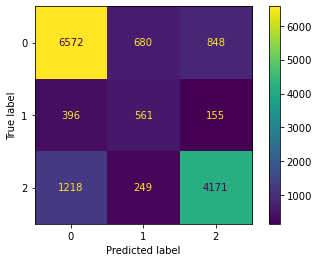

In [62]:
plot_confusion_matrix(RF_cls, X_dumie_test, y_test_enc)

Way too over-fit
#### Cross validation

In [63]:
cv_results1 = cross_validate(
                    estimator=RF_cls,
                    X=X_train_resample,
                    y=y_train_resample,
                    cv=5,
                    return_train_score=True, 
                    n_jobs=-2)

In [64]:
cv_results1['train_score'].mean()

0.9032555592499254

In [65]:
cv_results1['test_score'].mean()

0.8351622000659434

## RandomizedSearchCV

<br>

Will use RandomizedSearch to look for random best parameters, and use them as starting point for gridsearching.

In [68]:
grid_space={'bootstrap': [True, False], 
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
            'max_features': ['auto', 'sqrt'], 
            'min_samples_leaf': [1, 2, 4], 
            'min_samples_split': [2, 5, 10], 
            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
#note dont re-run cell below, took 5 hrs

In [69]:
random_search = RandomizedSearchCV(estimator = RF_cls, 
                                   param_distributions = grid_space, 
                                   n_iter = 100, 
                                   cv = 10, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs = -2)


random_search.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed: 60.4min
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed: 117.5min
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed: 280.7min
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed: 385.6min finished


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
# RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
#                    n_iter=100, n_jobs=-2,
#                    param_distributions={'bootstrap': [True, False],
#                                         'max_depth': [10, 20, 30, 40, 50, 60,
#                                                       70, 80, 90, 100, None],
#                                         'max_features': ['auto', 'sqrt'],
#                                         'min_samples_leaf': [1, 2, 4],
#                                         'min_samples_split': [2, 5, 10],
#                                         'n_estimators': [200, 400, 600, 800,
#                                                          1000, 1200, 1400, 1600,
#                                                          1800, 2000]},
#                    random_state=42, verbose=2)

In [70]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=200,
                       random_state=42)

In [ ]:
# RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=200,
#                        random_state=42)

In [71]:
random_search.best_score_

0.8425446923154013

In [ ]:
# 0.8425446923154013

In [74]:
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [ ]:
# {'n_estimators': 200,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': None,
#  'bootstrap': False}

Random search narrows down the number of posible parameter to try in grid search

In [76]:
random_search.classes_

array([0, 1, 2])

In [ ]:
# array([0, 1, 2])

In [77]:
random_search.n_features_in_

2144

In [ ]:
# 2144

###### Built Random Forest model using best parameters from RandomSearch

In [82]:
RF_cls2 = RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=200, 
                                 random_state=42, n_jobs=-2)

RF_cls2.fit(X_train_resample, y_train_resample)

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=200,
                       n_jobs=-2, random_state=42)

In [83]:
RF_cls2.score(X_train_resample, y_train_resample)

0.9001200380810463

In [84]:
RF_cls2.score(X_dumie_test, y_test_enc)

0.7622895622895622

In [90]:
RF_cv = cross_validate(
                    estimator=RF_cls2,
                    X=X_train_resample,
                    y=y_train_resample,
                    cv=10,
                    return_train_score=True, 
                    n_jobs=-2)

In [91]:
RF_cv['train_score'].mean()

0.9015243322980604

In [92]:
RF_cv['test_score'].mean()

0.8425446923154013

Same accuracy score the random search gave us

# GridSearchCV

Now, will start tuning the given "best-parameter", and run a GridSearch with a small combination of them.

In [ ]:
"""
Best parameters


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}
 """

Will try  slightly increasing min min_samples_leaf and min_samples_split and look for a possible improvement 

#### 1st GridSearchCV

In [94]:
param_grid1 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [2, 3], 
              'min_samples_split': [3, 5], 
              'n_estimators': [150, 200, 250]}

In [197]:
grid_search = GridSearchCV(estimator = RF_cls, param_grid = param_grid1, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done 120 out of 120 | elapsed:  9.4min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [3, 5],
                         'n_estimators': [150, 200, 250]},
             verbose=2)

In [96]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=250, random_state=42)

In [200]:
grid_search.best_score_

0.806311974719843

It decreased our score.

<br>

will try another combination of those same parameters

#### 2nd GridSearchCV

In [98]:
param_grid2 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [3, 4], 
              'min_samples_split': [4, 6], 
              'n_estimators': [200, 250, 300]}

In [99]:
grid_search2 = GridSearchCV(estimator = RF_cls, param_grid = param_grid2, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search2.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 120 out of 120 | elapsed:  8.8min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [3, 4],
                         'min_samples_split': [4, 6],
                         'n_estimators': [200, 250, 300]},
             verbose=2)

In [100]:
grid_search2.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=300, random_state=42)

In [101]:
grid_search2.best_score_

0.7858225665274906

It decreased more our score, instead of increasing values for min_samples_leaf and min_samples_split, will bring them down in the next gridsearch

#### 3rd GridSearchCV

In [102]:
param_grid3 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1, 2], 
              'min_samples_split': [2, 3], 
              'n_estimators': [250, 300, 400]}

In [103]:
grid_search3 = GridSearchCV(estimator = RF_cls, param_grid = param_grid3, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search3.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-2)]: Done 120 out of 120 | elapsed: 41.3min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [250, 300, 400]},
             verbose=2)

In [104]:
grid_search3.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=400,
                       random_state=42)

In [105]:
grid_search3.best_score_

0.8427240578502302

In [107]:
grid_search3.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

Score got better than the other last two, will create random forest using those hyperparameters.

#### Built model using best parameters from 3rd grid search

In [108]:
RF_cls3 = RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=400, 
                                 random_state=42, n_jobs=-2)

RF_cls3.fit(X_train_resample, y_train_resample)

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=400,
                       n_jobs=-2, random_state=42)

In [109]:
RF_cv2 = cross_validate(estimator=RF_cls3, 
                        X=X_train_resample, 
                        y=y_train_resample, 
                        cv=10, 
                        return_train_score=True, 
                        n_jobs=-2)

In [110]:
RF_cv2['train_score'].mean()

0.9015243322980604

In [111]:
RF_cv2['test_score'].mean()

0.8427240578502302

Same results as the ones got straight from the RandomSearch, will try another Gridsearch

#### 4th GridSearchCV

In [112]:
param_grid4 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1], 
              'min_samples_split': [1, 2], 
              'n_estimators': [500, 1000]}

All other grid searches suggested the higher n_estimators as the best parameter, will increase a 100 more from the last one(400), and one of 1000 estimators

In [113]:
grid_search4 = GridSearchCV(estimator = RF_cls, param_grid = param_grid4, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search4.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed: 30.1min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 2],
                         'n_estimators': [500, 1000]},
             verbose=2)

In [114]:
grid_search4.best_score_

0.842627490906643

In [115]:
grid_search4.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=500,
                       random_state=42)

In [116]:
grid_search4.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

Model picked 500 over 1000 in the n_estimators parameter, will try another gridsearch using values between 400 and 500, if 500 is picked then ill try values close to 500 but not as high as 1000

#### 5th GridSearchCV

In [117]:
param_grid5 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1], 
              'min_samples_split': [1, 2], 
              'n_estimators': [400, 500, 600, 700]}

In [118]:
grid_search5 = GridSearchCV(estimator = RF_cls, param_grid = param_grid5, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search5.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed: 39.1min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 2],
                         'n_estimators': [400, 500, 600, 700]},
             verbose=2)

In [119]:
grid_search5.best_score_

0.842903423385059

In [120]:
grid_search5.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=600,
                       random_state=42)

In [121]:
grid_search5.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

Will run again with values around 600 in n_estimators


#### 6th GridSearchCV

In [124]:
param_grid6 = {'bootstrap': [False],
              'max_depth': [None], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1], 
              'min_samples_split': [2], 
              'n_estimators': [550, 600, 650]}

In [125]:
grid_search6 = GridSearchCV(estimator = RF_cls, param_grid = param_grid6, 
                          cv = 10, n_jobs = -2, verbose = 2, )

grid_search6.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  30 out of  30 | elapsed: 35.5min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [550, 600, 650]},
             verbose=2)

In [126]:
grid_search6.best_score_

0.8429310133964242

In [127]:
grid_search6.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=650,
                       random_state=42)

In [128]:
grid_search6.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 650}

In [196]:
grid_search6.cv_results_['mean_test_score']

array([0.84277925, 0.84290342, 0.84293101])

### Random forest with new parameters 

In [136]:
RF_cls4 = RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=650, min_samples_leaf= 1, 
                                 min_samples_split = 2,
                                 random_state=42, n_jobs=-2)

RF_cls4.fit(X_train_resample, y_train_resample)

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=650,
                       n_jobs=-2, random_state=42)

In [145]:
RF_cv4 = cross_validate(estimator=RF_cls4, 
                        X=X_train_resample, 
                        y=y_train_resample, 
                        cv=10, 
                        return_train_score=True, 
                        n_jobs=-2)

In [146]:
RF_cv4['train_score'].mean()

0.9015243322980604

In [147]:
RF_cv4['test_score'].mean()

0.8429310133964242

Will try fix overfitting and run search with following parameter with different max_debt

#### 7th GridSearchCV

In [150]:
param_grid7 = {'bootstrap': [False],
              'max_depth': [5, 15], 
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1], 
              'min_samples_split': [2], 
              'n_estimators': [650]}

In [151]:
grid_search7 = GridSearchCV(estimator = RF_cls, param_grid = param_grid7, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search7.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 out of  20 | elapsed:  1.0min remaining:    6.8s
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed:  1.0min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth': [5, 15],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [650]},
             verbose=2)

In [198]:
grid_search7.best_score_

0.6826307799284229

In [153]:
grid_search7.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=650,
                       random_state=42)

In [154]:
grid_search7.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 650}

Tunning max_depth brought down our score by a significant amount

#### 8th GridSearchCV

In [284]:
param_grid8 = {'bootstrap': [False], 
              'min_samples_leaf': [1], 
              'min_samples_split': [2], 
              'n_estimators': [650], 
               'max_features': ["log2"]
              }

In [285]:
grid_search8 = GridSearchCV(estimator = RF_cls, param_grid = param_grid8, 
                          cv = 10, n_jobs = -2, verbose = 2)

grid_search8.fit(X_train_resample, y_train_resample)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 out of  20 | elapsed: 66.0min remaining:  7.3min
[Parallel(n_jobs=-2)]: Done  20 out of  20 | elapsed: 68.3min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_features': [None, 'log2'],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [650]},
             verbose=2)

In [288]:
grid_search8.best_score_

0.8451110050562143

In [287]:
grid_search8.best_params_

{'bootstrap': False,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 650}

In [294]:
RF_cls8 = RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=650, min_samples_leaf= 1, 
                                 min_samples_split = 2,
                                 random_state=42, n_jobs=-2)

RF_cls8.fit(X_train_resample, y_train_resample)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=650,
                       n_jobs=-2, random_state=42)

In [295]:
RF_cv8 = cross_validate(estimator=RF_cls8, 
                        X=X_train_resample, 
                        y=y_train_resample, 
                        cv=10, 
                        return_train_score=True, 
                        n_jobs=-2)

In [296]:
RF_cv8['train_score'].mean()

0.9015243322980604

In [297]:
RF_cv8['test_score'].mean()

0.8451110050562143

it improved a little by changing max_features 

<br>

### Gradient boosting
#### 9th GridSearchCV

In [370]:
# # Instantiate an GradientBoostingClassifier
# gbt_clf = GradientBoostingClassifier(random_state=42)

In [371]:
# gbt_clf.fit(X_train_resample, y_train_resample)

GradientBoostingClassifier(random_state=42)

In [378]:
# gbt_clf_train_preds = gbt_clf.predict(X_train_resample)
# gbt_clf_train_preds.mean()

0.8092912234226031

In [379]:
# gbt_clf_test_preds = gbt_clf.predict(X_dumie_test)
# gbt_clf_test_preds.mean()

0.7200673400673401

In [ ]:
# param_grid9 = {'bootstrap': [False], 
#               'min_samples_leaf': [1], 
#               'min_samples_split': [2], 
#               'n_estimators': [650], 
#                'max_features': ["log2"]
#               }

In [ ]:
# grid_search9 = GridSearchCV(estimator = RF_cls, param_grid = param_grid9, 
#                           cv = 10, n_jobs = -2, verbose = 2)

# grid_search9.fit(X_train_resample, y_train_resample)

In [ ]:
# grid_search9.best_score_

In [ ]:
# grid_search9.best_params_

## Best Model 
(so far)

In [289]:
Best_model = grid_search8

In [292]:
Best_model.best_score_

0.8451110050562143

In [293]:
Best_model.best_params_

{'bootstrap': False,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 650}

In [298]:
b_train = RF_cv8['train_score'].mean()
b_test =RF_cv8['test_score'].mean()

print(f'Cross Validation mean train score:{b_train}')
print(f'Cross Validation mean Test score: {b_test}')

Cross Validation mean train score:0.9015243322980604
Cross Validation mean Test score: 0.8451110050562143


In [186]:
name = {
    'Class' : ['functional', 'functional needs repair', 'non functional'],
    'Enconded class' : [0, 1, 2]}
class_nm = pd.DataFrame(name)
class_nm

,Class,Enconded class
0,functional,0
1,functional needs repair,1
2,non functional,2


### Confusion Matrices

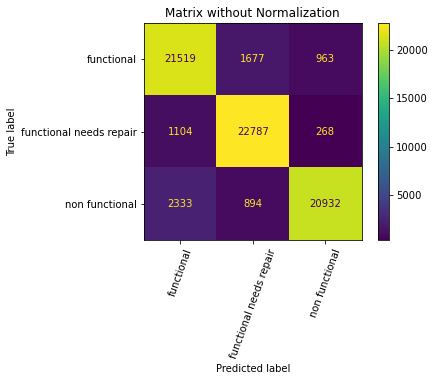

In [299]:
cmx = plot_confusion_matrix(Best_model, X_train_resample, y_train_resample,
                            display_labels=encoder.classes_,
                            xticks_rotation=70)
cmx.ax_.set_title('Matrix without Normalization')

plt.show()

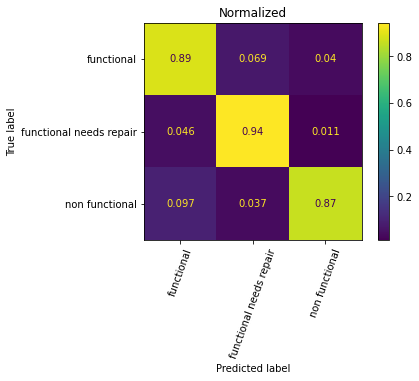

<Figure size 432x288 with 0 Axes>

In [485]:
cmx2 = plot_confusion_matrix(Best_model, X_train_resample, y_train_resample,
                            display_labels=encoder.classes_,
                                   normalize='true',
                                   xticks_rotation=70)
cmx2.ax_.set_title('Normalized')

plt.show()
#plt.savefig("./Confusion-matrix-not-transparent.png", bbox_inches="tight", transparent=False, dpi=600);

#### Feature importance

In [354]:
feature_importances = Best_model.best_estimator_.feature_importances_
feature_names = ohe.get_feature_names().tolist()
Feat_names=['Quantity - Dry', 'Quantity - Enough', 'Extraction type - Other', 'Waterpoint type - Other',
   'Quantity - Insufficient', 'Payment - Never pay', 'Payment - Per bucket', 'Extraction type - Gravity',
  'Waterpoint type - Communal standpipe', 'Payment - Monthly']

In [422]:
def plot_feature_importance(importance,names,model_type, n=10):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df=fi_df.head(n)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=Feat_names, palette="ch:start=.2,rot=-.3_r")


    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    

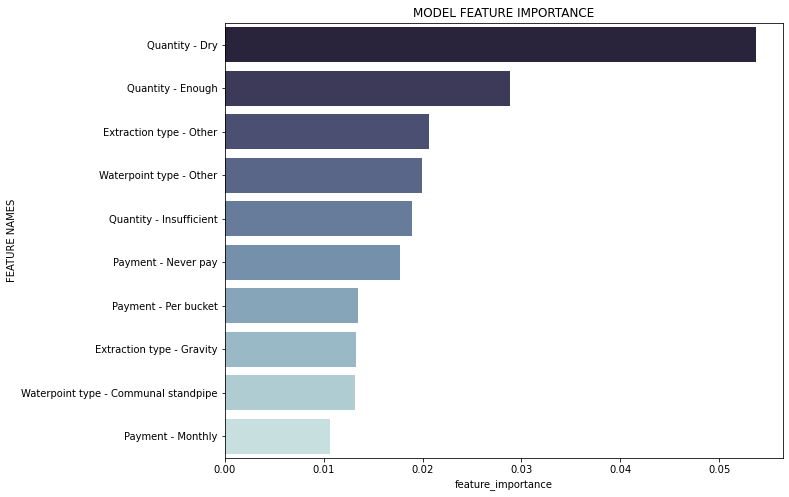

In [484]:
plot_feature_importance(feature_importances,feature_names,'MODEL')
#plt.savefig("./FEATURE_IMPORTANCE-not-transparent.png", bbox_inches="tight", transparent=False, dpi=600);

### Best Model Vs baseline model Graph

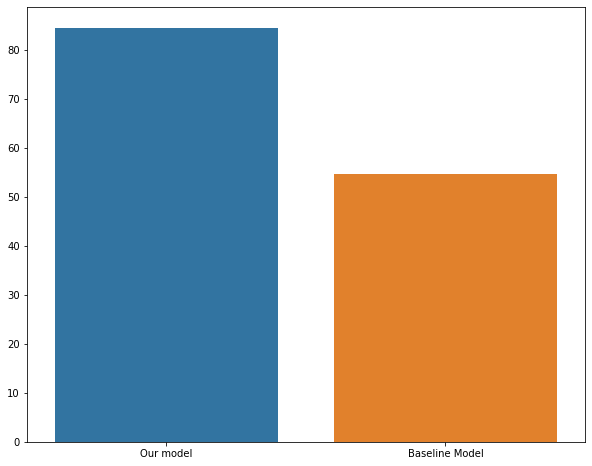

In [483]:
best_vs_base_score = [Best_model.best_score_*100, dummy_clf.score(X_dumie_test, y_test_enc)*100]
best_vs_base_score_names = ['Our model', 'Baseline Model']

plt.figure(figsize=(10,8))

sns.barplot(x=best_vs_base_score_names, y=best_vs_base_score, orient='v');
#plt.savefig("./comparasion_graph-no-transparent.png", bbox_inches="tight", transparent=False, dpi=600);

# unused code

 will create a column showing if the record was taken on dry month or other, using the date_recorder column


https://www.nathab.com/know-before-you-go/african-safaris/east-africa/weather-climate/tanzania/#:~:text=The%20dry%20season%2C%20with%20cooler,a%20chance%20of%20afternoon%20showers.


The dry season, with cooler temperatures, lasts from May to October.

Summer usually lasts from November to March, and during this time there is always a chance of afternoon showers. 

and april shows the highes average of inches of rain per month

jan is considered a short dry season between, months that rains alot.




df_Dropped['date_recorded'][1][5:7]

https://altezza.travel/en/articles/weather

df_Dropped['season'] = pd.DatetimeIndex(df_Dropped['date_recorded']).month

df_Dropped ['precipitation (mm)'] = df_Dropped['season'].map({1:49, 2:30, 3:85, 4:153, 5:126, 6:32,
                                                         7:13, 8:18, 9:21, 10:48, 11:132, 12:75})
df_Dropped.head ( )

df_Dropped.drop(columns=['season', 'date_recorded'], inplace=True)

df_Dropped

## creating a simple model 

X = df_Dropped.drop(columns=['status_group', 'management', 'management_group', 
                             'scheme_management', 'scheme_name', 'permit'])
y = df_Dropped['status_group']

X_dummie = pd.get_dummies(data= X,  drop_first=True)

X_dummie

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_dummie, y)

tree_clf.score(X_dummie, y)

def plot_feature_importances(model):
    n_features = X_train_resample.shape[1]
    plt.figure(figsize=(10,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_resample.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(Simple_tree_2)

overfit model

pd.DataFrame(X_train_resample)

Simple_tree_2.score(X_dumie_test, y_test)

Simple_tree_2.score(X_train_resample, y_train_resample)

plot_confusion_matrix(Simple_tree_2, X_train_resample, y_train_resample);